<a href="https://colab.research.google.com/github/sasa10th/Contest/blob/main/Contest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [123]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.spatial.distance import mahalanobis
from datetime import timedelta

In [ ]:
LABEL_PALETTE = {'A': '#F4A261', 'B': '#E76F51', 'C': '#2A9D8F'}

In [ ]:
plt.rc('font', family='NanumBarunGothic')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/MyDataRoomDB-accEvent.csv")
df['readable_time'] = pd.to_datetime(df['timestamp'], unit='ms')
df['mag'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             25200 non-null  int64         
 1   pid            25200 non-null  object        
 2   label          25200 non-null  object        
 3   timestamp      25200 non-null  int64         
 4   dataReceived   25200 non-null  int64         
 5   x              25200 non-null  float64       
 6   y              25200 non-null  float64       
 7   z              25200 non-null  float64       
 8   readable_time  25200 non-null  datetime64[ns]
 9   mag            25200 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 1.9+ MB


,id,pid,label,timestamp,dataReceived,x,y,z,readable_time,mag
0,301,신재윤,A,1753256006140,1753256018172,-0.756838,2.701623,8.909609,2025-07-23 07:33:26.140,9.340915
1,302,신재윤,A,1753256006180,1753256018175,-0.807134,2.720784,9.182646,2025-07-23 07:33:26.180,9.611197
2,303,신재윤,A,1753256006220,1753256018176,-0.845455,2.723179,9.144324,2025-07-23 07:33:26.220,9.578578
3,304,신재윤,A,1753256006260,1753256018177,-0.881381,2.526784,9.266473,2025-07-23 07:33:26.260,9.645154
4,305,신재윤,A,1753256006300,1753256018179,-0.991553,2.670488,9.165880,2025-07-23 07:33:26.300,9.598335


/tmp/ipython-input-57-1744299775.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=LABEL_PALETTE)


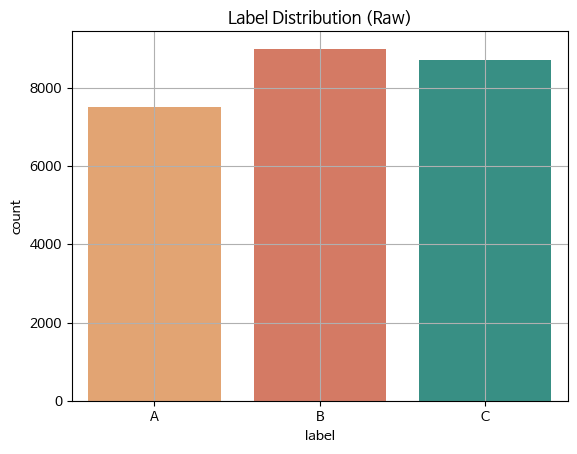

In [ ]:
sns.countplot(x='label', data=df, palette=LABEL_PALETTE)
plt.title("Label Distribution (Raw)")
plt.grid(True)
plt.show()

/tmp/ipython-input-58-204932438.py:5: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


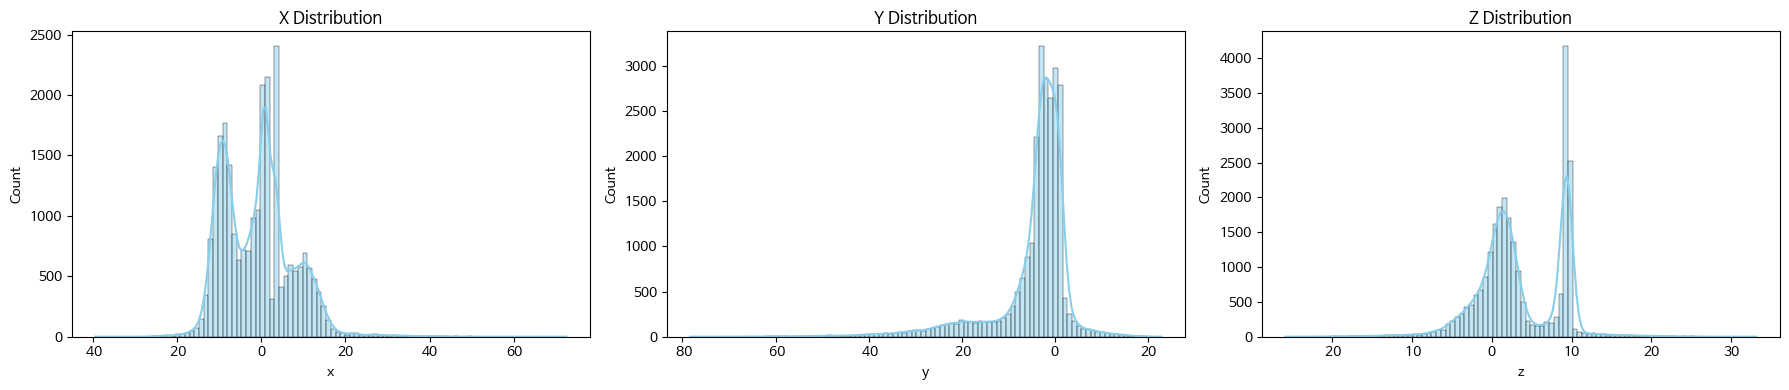

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for i, axis in enumerate(['x', 'y', 'z']):
    sns.histplot(df[axis], bins=100, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f"{axis.upper()} Distribution")
plt.tight_layout()
plt.show()

In [174]:
def iqr_outlier_ratio(window: pd.DataFrame, factor=1.5):
    outlier_mask = np.zeros(len(window), dtype=bool)
    for axis in ['x', 'y', 'z']:
        q1 = window[axis].quantile(0.25)
        q3 = window[axis].quantile(0.75)
        iqr = q3 - q1
        low = q1 - factor * iqr
        high = q3 + factor * iqr
        outlier_mask |= (window[axis] < low) | (window[axis] > high)
    return outlier_mask.sum() / len(window)

def windowed_ocsvm_iqr(df: pd.DataFrame, window_size=100, step=50, factor=1.5, min_nu=0.005, max_nu=0.05):
    n = len(df)
    is_inlier_mask = np.zeros(n, dtype=bool)

    for start in range(0, n - window_size + 1, step):
        end = start + window_size
        window = df.iloc[start:end].copy()
        X = window[['x', 'y', 'z']].values

        nu = np.clip(iqr_outlier_ratio(window, factor), min_nu, max_nu)

        ocsvm = OneClassSVM(kernel='rbf', nu=nu, gamma='scale')
        pred = ocsvm.fit_predict(X) == 1

        is_inlier_mask[start:end] |= pred

    return is_inlier_mask

df['is_inlier'] = windowed_ocsvm_iqr(df, window_size=100, step=50)
df_clean = df[df['is_inlier']].reset_index(drop=True)

print(f"Removed outliers: {len(df) - len(df_clean)}")

Removed outliers: 473


/tmp/ipython-input-175-2187608037.py:7: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


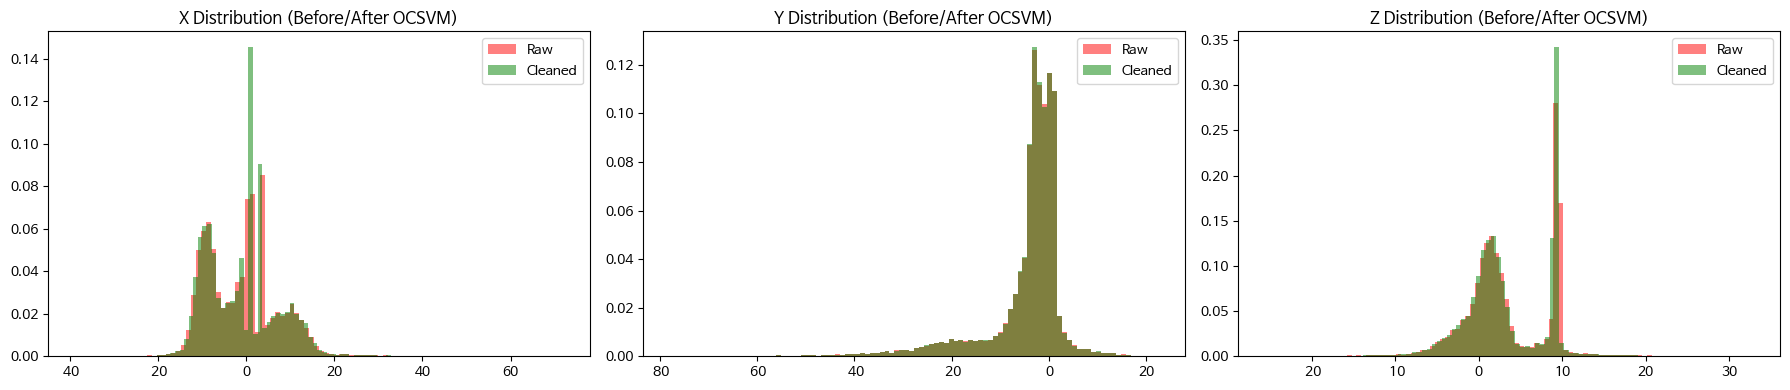

In [175]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for i, axis in enumerate(['x', 'y', 'z']):
    axes[i].hist(df[axis], bins=100, alpha=0.5, label='Raw', color='red', density=True)
    axes[i].hist(df_clean[axis], bins=100, alpha=0.5, label='Cleaned', color='green', density=True)
    axes[i].set_title(f"{axis.upper()} Distribution (Before/After OCSVM)")
    axes[i].legend()
plt.tight_layout()
plt.show()

/tmp/ipython-input-176-3394170966.py:8: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()


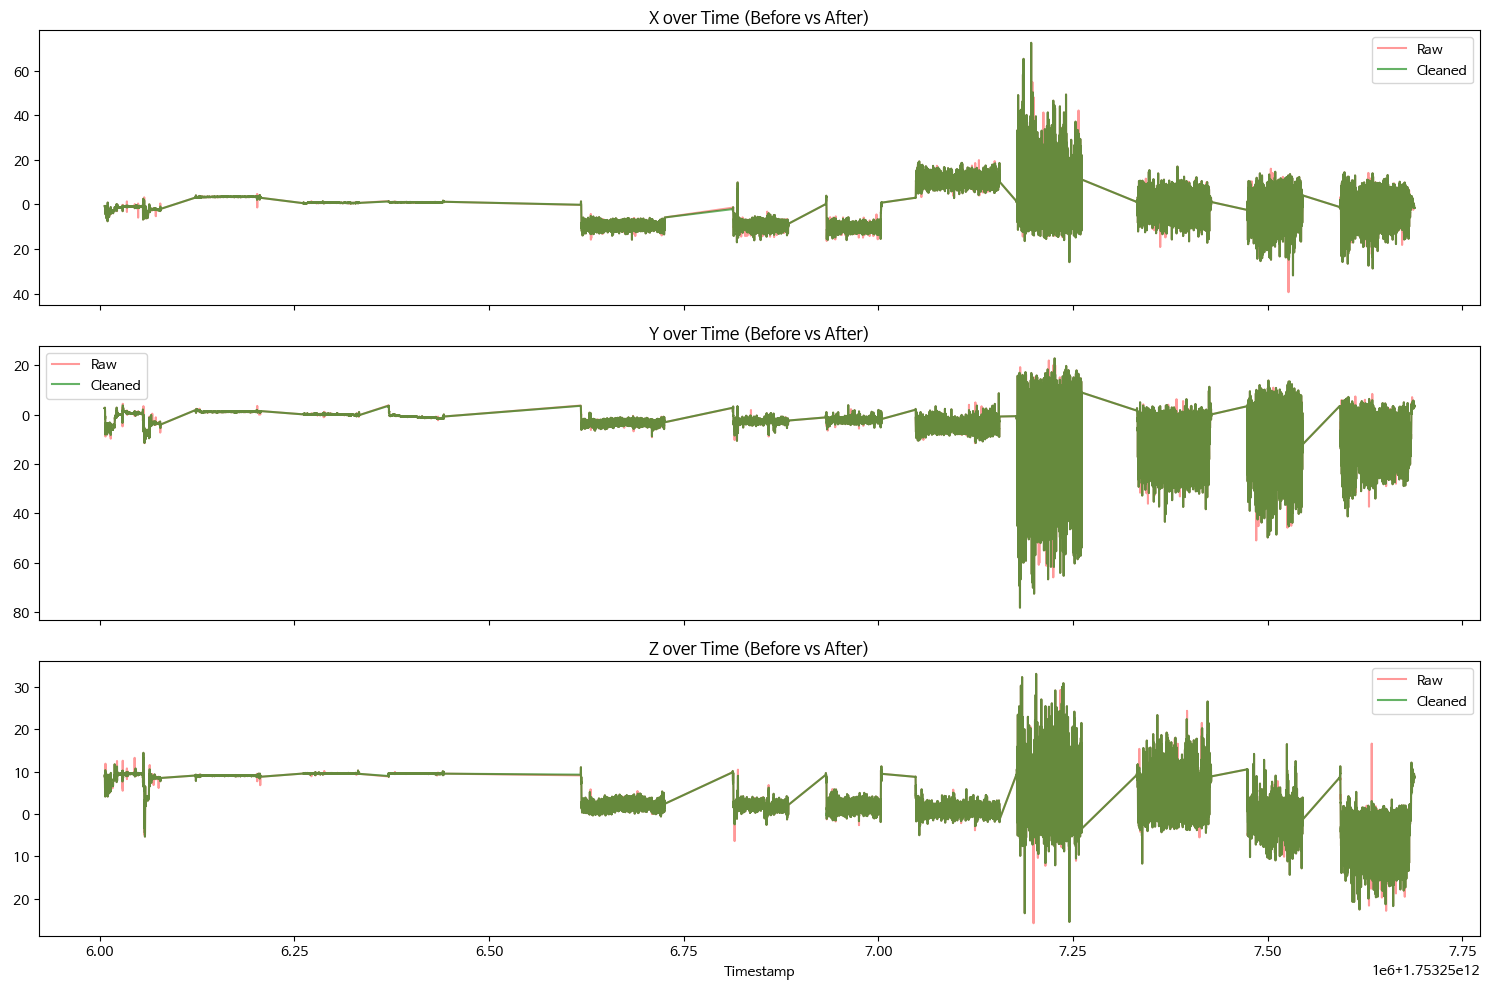

In [176]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
for i, axis in enumerate(['x', 'y', 'z']):
    axes[i].plot(df['timestamp'], df[axis], label='Raw', color='red', alpha=0.4)
    axes[i].plot(df_clean['timestamp'], df_clean[axis], label='Cleaned', color='green', alpha=0.6)
    axes[i].set_title(f"{axis.upper()} over Time (Before vs After)")
    axes[i].legend()
axes[-1].set_xlabel("Timestamp")
plt.tight_layout()
plt.show()

In [177]:
df_trimmed = []
for pid, group in df_clean.groupby("pid"):
    t0, t1 = group["timestamp"].min(), group["timestamp"].max()
    trimmed = group[(group["timestamp"] >= t0 + 5000) & (group["timestamp"] <= t1 - 5000)]
    df_trimmed.append(trimmed)
df_clean = pd.concat(df_trimmed, ignore_index=True)

In [178]:
WINDOW_SIZE = 25
STEP_SIZE = 12
features, labels = [], []

df_clean = df_clean.sort_values("timestamp")
for i in range(0, len(df_clean) - WINDOW_SIZE, STEP_SIZE):
    window = df_clean.iloc[i:i+WINDOW_SIZE]
    if len(window['label'].unique()) > 1:
        continue
    feat = []
    for axis in ['x', 'y', 'z']:
        v = window[axis].values
        feat.extend([np.mean(v), np.std(v), np.min(v), np.max(v)])
    features.append(feat)
    labels.append(window['label'].iloc[0])

X = np.array(features)
y = np.array(labels)

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [180]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       113
           B       1.00      1.00      1.00       148
           C       1.00      1.00      1.00       134

    accuracy                           1.00       395
   macro avg       1.00      1.00      1.00       395
weighted avg       1.00      1.00      1.00       395



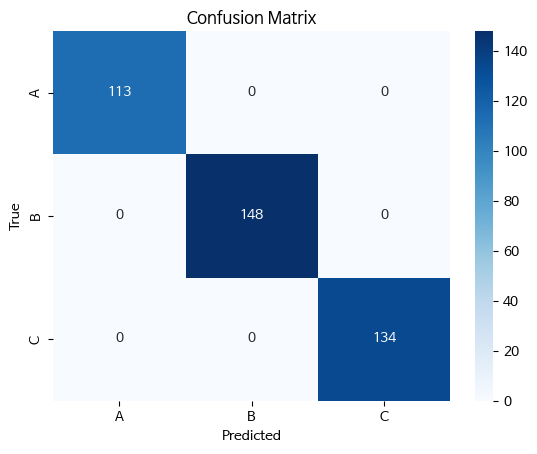

In [181]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(np.unique(y)), yticklabels=sorted(np.unique(y)))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


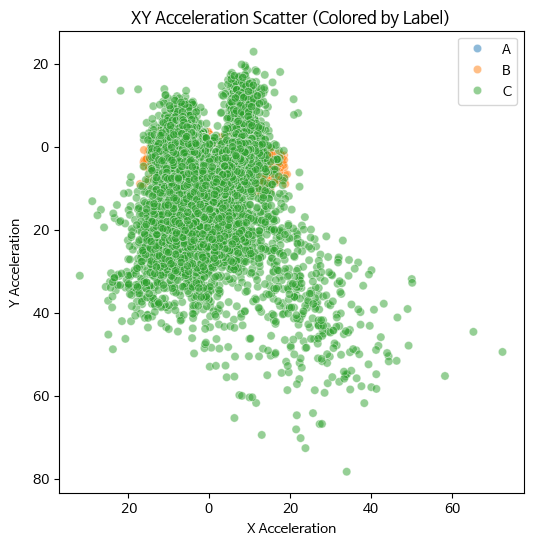

In [182]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_clean, x='x', y='y', hue='label', alpha=0.5)
plt.title("XY Acceleration Scatter (Colored by Label)")
plt.xlabel("X Acceleration")
plt.ylabel("Y Acceleration")
plt.legend()
plt.show()

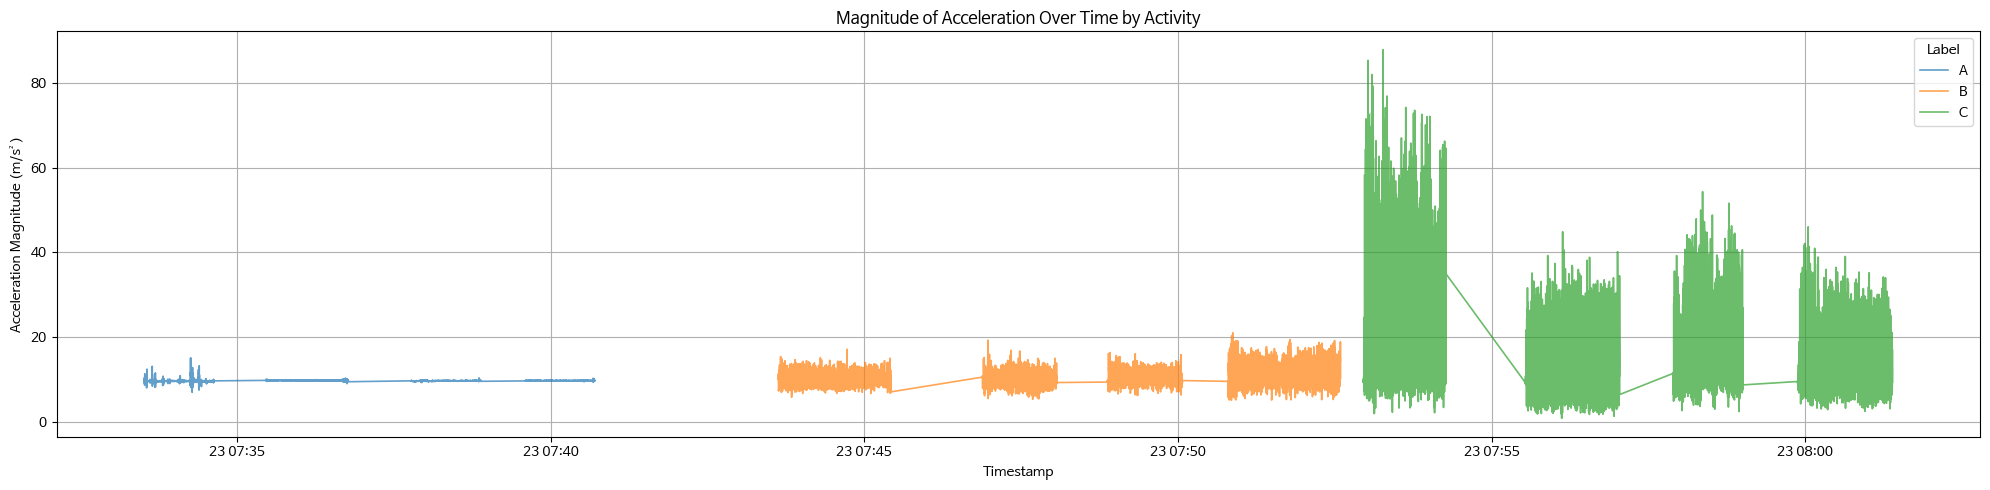

In [183]:
df_clean['readable_time'] = pd.to_datetime(df_clean['timestamp'], unit='ms')
df_clean['mag'] = np.sqrt(df_clean['x']**2 + df_clean['y']**2 + df_clean['z']**2)
plt.figure(figsize=(20, 5))
sns.lineplot(data=df_clean, x='readable_time', y='mag', hue='label', linewidth=1.2, alpha=0.7)

plt.title("Magnitude of Acceleration Over Time by Activity")
plt.xlabel("Timestamp")
plt.ylabel("Acceleration Magnitude (m/s²)")
plt.legend(title='Label')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-184-3499494449.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_label_sampled = df_label.groupby('pid').apply(lambda x: x.iloc[::5]).reset_index(drop=True)


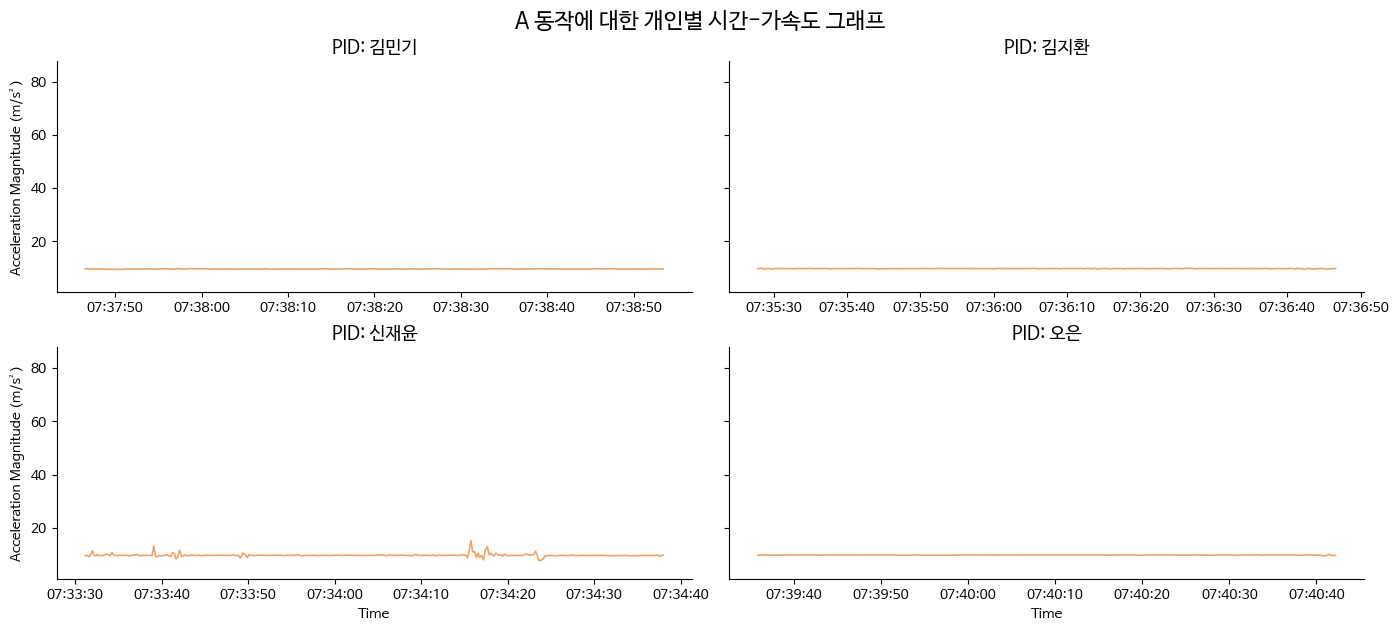

/tmp/ipython-input-184-3499494449.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_label_sampled = df_label.groupby('pid').apply(lambda x: x.iloc[::5]).reset_index(drop=True)


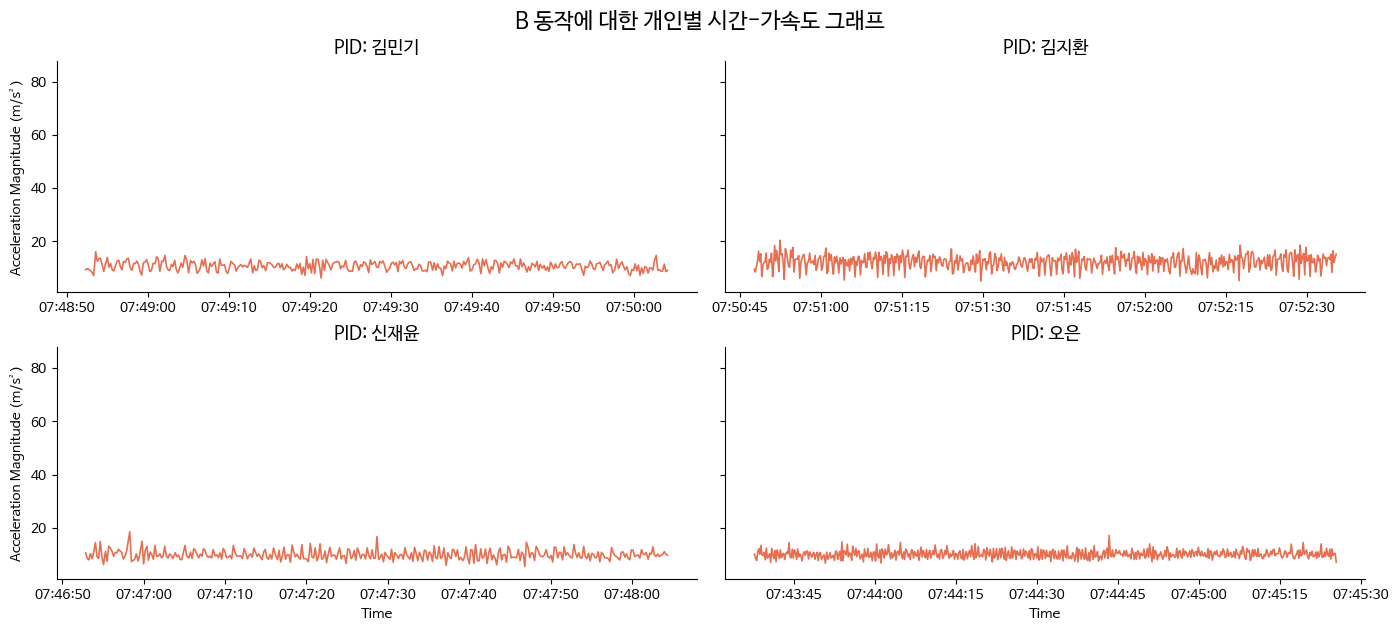

/tmp/ipython-input-184-3499494449.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_label_sampled = df_label.groupby('pid').apply(lambda x: x.iloc[::5]).reset_index(drop=True)


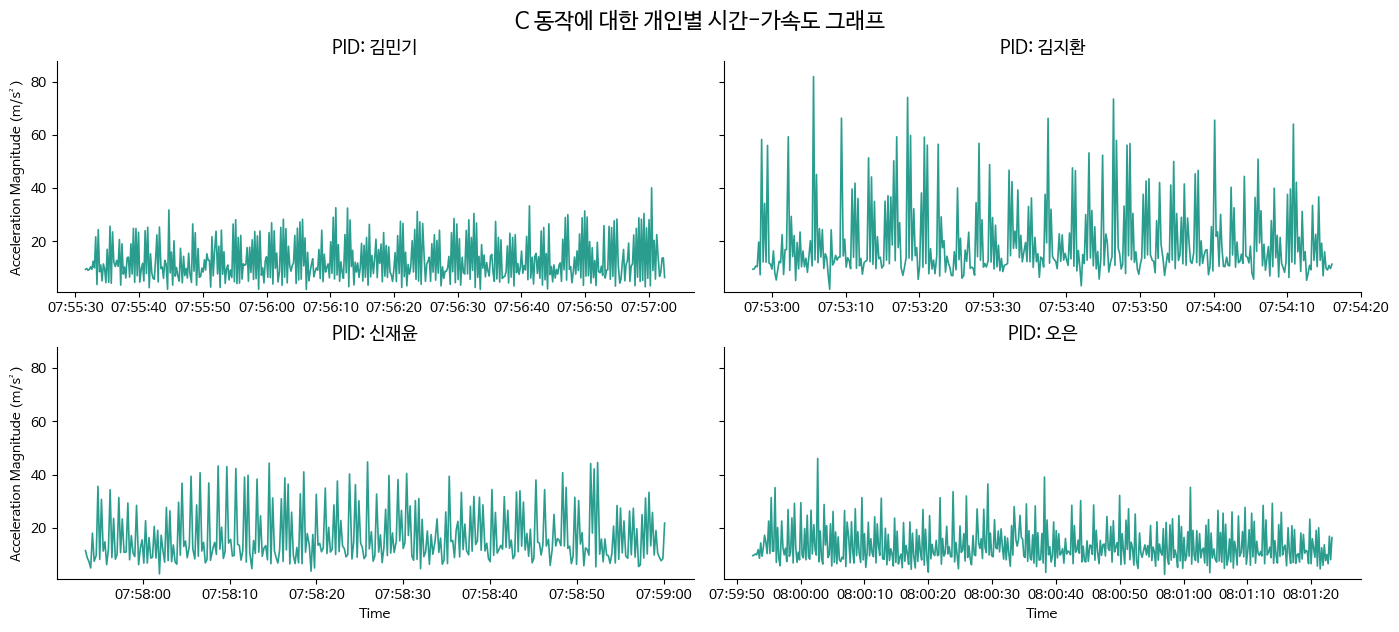

In [184]:
df_clean['readable_time'] = pd.to_datetime(df_clean['timestamp'], unit='ms')
df_clean['mag'] = np.sqrt(df_clean['x']**2 + df_clean['y']**2 + df_clean['z']**2)

palette = {'A': '#F4A261', 'B': '#E76F51', 'C': '#2A9D8F'}

mag_min = df_clean['mag'].min()
mag_max = df_clean['mag'].max()

for label in sorted(df_clean['label'].unique()):
    df_label = df_clean[df_clean['label'] == label].copy()
    df_label_sampled = df_label.groupby('pid').apply(lambda x: x.iloc[::5]).reset_index(drop=True)

    g = sns.relplot(
        data=df_label_sampled,
        x='readable_time',
        y='mag',
        col='pid',
        kind='line',
        col_wrap=2,
        height=3.2,
        aspect=2.2,
        linewidth=1.2,
        color=palette.get(label, 'gray'),
        facet_kws={'sharey': True, 'sharex': False}
    )

    for ax in g.axes.flat:
        ax.set_ylim(mag_min, mag_max)

    if g._legend is not None:
        g._legend.remove()

    g.set_titles("PID: {col_name}", size=13)
    g.set_axis_labels("Time", "Acceleration Magnitude (m/s²)")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f"{label} 동작에 대한 개인별 시간-가속도 그래프", fontsize=16)
    plt.show()

/tmp/ipython-input-185-1679242213.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted(np.unique(y)), y=accuracies, palette=LABEL_PALETTE)


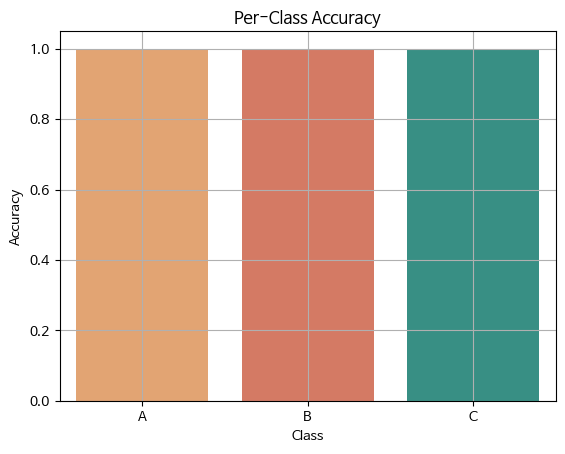

In [185]:
accuracies = [accuracy_score(y_test[y_test == l], y_pred[y_test == l]) for l in sorted(np.unique(y))]
sns.barplot(x=sorted(np.unique(y)), y=accuracies, palette=LABEL_PALETTE)
plt.ylim(0, 1.05)
plt.title("Per-Class Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

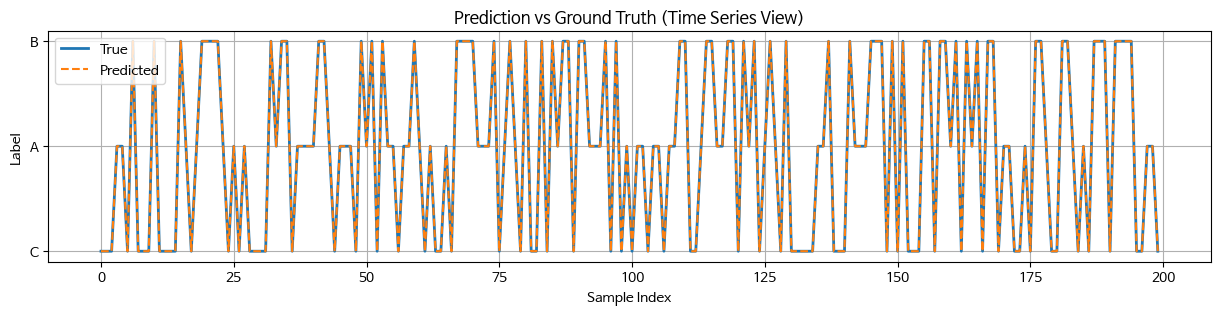

In [186]:
plt.figure(figsize=(15,3))
plt.plot(y_test[:200], label="True", linewidth=2)
plt.plot(y_pred[:200], label="Predicted", linestyle="--")
plt.title("Prediction vs Ground Truth (Time Series View)")
plt.ylabel("Label")
plt.xlabel("Sample Index")
plt.legend()
plt.grid(True)
plt.show()